До ремонта: 196 записей
После ремонта: 269 записей


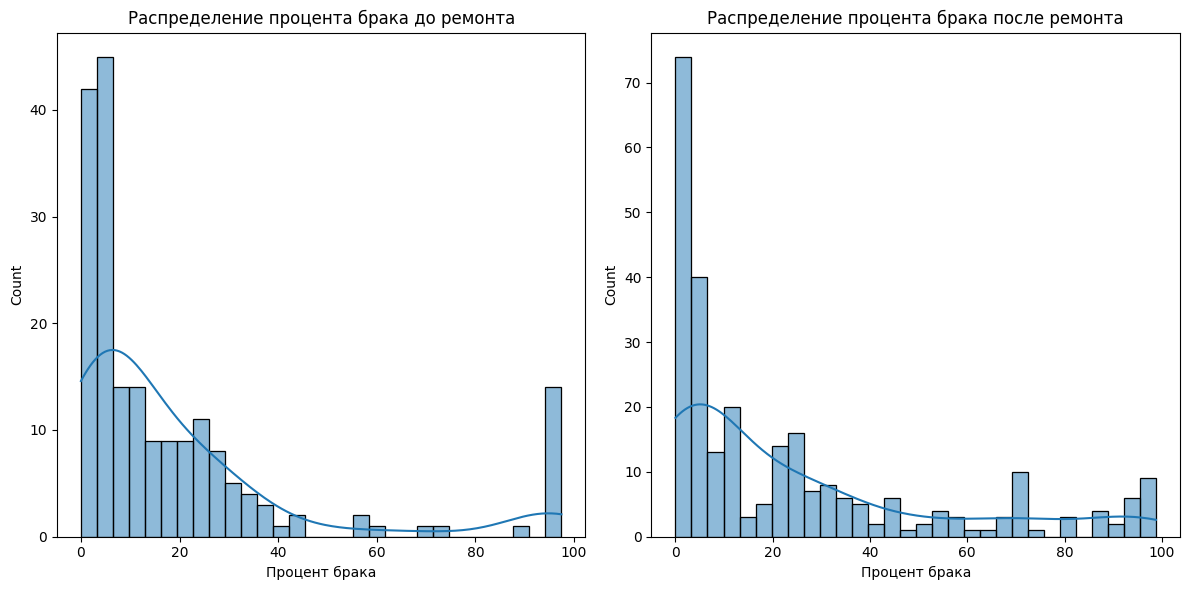

Описательная статистика ДО ремонта:
count    196.000000
mean      19.382449
std       25.469620
min        0.000000
25%        3.645000
50%        8.650000
75%       25.037500
max       97.440000
Name: Процент_брака, dtype: float64

Описательная статистика ПОСЛЕ ремонта:
count    269.000000
mean      24.133457
std       28.702100
min        0.000000
25%        2.940000
50%       10.950000
75%       34.020000
max       98.800000
Name: Процент_брака, dtype: float64

Результаты статистического теста:
T-статистика: 1.8821
P-value: 0.969762

Средний процент брака ДО ремонта: 19.38%
Средний процент брака ПОСЛЕ ремонта: 24.13%
Разница: -4.75%

❌ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА:
Нет статистически значимого снижения процента брака после ремонта


Анализ по номерам моделей:
   Модель  До_ремонта  После_ремонта    Разница  Улучшение
7     185   77.526190      56.974516  20.551674       True
3     164   15.544000       4.414000  11.130000       True
8     187   24.346000      16.302000   8.044000       T

In [2]:
# A/B тестирование для проверки гипотезы: процент брака после ремонта модельной оснастки ниже, чем до ремонта (с порогом 5%).
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df_before = pd.read_excel('до_прибытия.xlsx', sheet_name='Page 1')
df_after = pd.read_excel('после_прибытия.xlsx', sheet_name='Page 1')

# Предобработка данных
def preprocess_data(df):
    # Удаляем строки с пропусками в ключевых столбцах
    df = df.dropna(subset=['Процент_брака'])
    # Удаляем строки, где процент брака не числовой
    df = df[pd.to_numeric(df['Процент_брака'], errors='coerce').notnull()]
    df['Процент_брака'] = df['Процент_брака'].astype(float)
    return df

df_before_clean = preprocess_data(df_before)
df_after_clean = preprocess_data(df_after)

print(f"До ремонта: {len(df_before_clean)} записей")
print(f"После ремонта: {len(df_after_clean)} записей")

# Визуализация распределения
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_before_clean['Процент_брака'], kde=True, bins=30)
plt.title('Распределение процента брака до ремонта')
plt.xlabel('Процент брака')

plt.subplot(1, 2, 2)
sns.histplot(df_after_clean['Процент_брака'], kde=True, bins=30)
plt.title('Распределение процента брака после ремонта')
plt.xlabel('Процент брака')

plt.tight_layout()
plt.show()

# Описательная статистика
print("Описательная статистика ДО ремонта:")
print(df_before_clean['Процент_брака'].describe())
print("\nОписательная статистика ПОСЛЕ ремонта:")
print(df_after_clean['Процент_брака'].describe())

# Проверка гипотезы: процент брака после ремонта НИЖЕ, чем до ремонта
# H0: mean_after >= mean_before (разницы нет или стало хуже)
# H1: mean_after < mean_before (стало лучше)

# T-тест для независимых выборок (односторонний)
t_stat, p_value = stats.ttest_ind(
    df_after_clean['Процент_брака'],
    df_before_clean['Процент_брака'],
    alternative='less',  # односторонний тест: после < до
    equal_var=False      # Уэлча (разные дисперсии)
)

print(f"\nРезультаты статистического теста:")
print(f"T-статистика: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Проверка практической значимости (разница > 5%)
mean_before = df_before_clean['Процент_брака'].mean()
mean_after = df_after_clean['Процент_брака'].mean()
difference = mean_before - mean_after

print(f"\nСредний процент брака ДО ремонта: {mean_before:.2f}%")
print(f"Средний процент брака ПОСЛЕ ремонта: {mean_after:.2f}%")
print(f"Разница: {difference:.2f}%")

# Вывод результатов
alpha = 0.05  # уровень значимости

if p_value < alpha and difference > 5:
    print("\n✅ ГИПОТЕЗА ПОДТВЕРЖДЕНА:")
    print("Процент брака после ремонта статистически значимо ниже,")
    print(f"и разница ({difference:.2f}%) превышает порог в 5%")
elif p_value < alpha and difference <= 5:
    print("\n⚠️  Частичное подтверждение:")
    print("Процент брака после ремонта статистически значимо ниже,")
    print(f"но разница ({difference:.2f}%) не достигает порога в 5%")
else:
    print("\n❌ ГИПОТЕЗА НЕ ПОДТВЕРЖДЕНА:")
    print("Нет статистически значимого снижения процента брака после ремонта")

# Дополнительный анализ по моделям (опционально)
print("\n\nАнализ по номерам моделей:")
models = set(df_before_clean['Номер_модели']).union(set(df_after_clean['Номер_модели']))

results_by_model = []
for model in models:
    before_model = df_before_clean[df_before_clean['Номер_модели'] == model]['Процент_брака']
    after_model = df_after_clean[df_after_clean['Номер_модели'] == model]['Процент_брака']

    if len(before_model) > 5 and len(after_model) > 5:  # Минимальное количество данных
        mean_before_m = before_model.mean()
        mean_after_m = after_model.mean()
        diff_m = mean_before_m - mean_after_m

        results_by_model.append({
            'Модель': model,
            'До_ремонта': mean_before_m,
            'После_ремонта': mean_after_m,
            'Разница': diff_m,
            'Улучшение': diff_m > 5
        })

# Сортировка по улучшению
results_df = pd.DataFrame(results_by_model).sort_values('Разница', ascending=False)
print(results_df.head(10))  # Топ-10 моделей с наибольшим улучшением